In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load Data

### Crypto Tweets / News

#### Read Data

In [25]:
data_raw = pd.read_csv("../res/input/cryptonews.csv")

data_raw = data_raw.iloc[:5, :]

In [26]:
data_raw.describe()

,date,sentiment,source,subject,text,title,url
count,101,101,101,101,101,101,101
unique,98,74,3,6,100,101,101
top,2023-04-04 15:00:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,altcoin,"Get your daily, bite-sized digest of cryptoass...",Allbridge to first begin repaying stuck bridge...,https://cointelegraph.com/news/allbridge-to-fi...
freq,2,26,50,37,2,1,1


In [27]:
data_raw.isnull().sum()

date         0
sentiment    0
source       0
subject      0
text         0
title        0
url          0
dtype: int64

In [28]:
df_tweets = data_raw.copy(deep=True)

# Convert sentiment column from string to dict
df_tweets['sentiment'] = df_tweets['sentiment'].apply(eval)

# Split dictionary in separate columns
sentiment_df = pd.json_normalize(df_tweets['sentiment'])
df_tweets = pd.concat([df_tweets, sentiment_df], axis=1)

df_tweets = df_tweets.drop(columns=["sentiment", "url"])

df_tweets.head()

,date,source,subject,text,title,class,polarity,subjectivity
0,2023-04-05 06:52:09,CoinTelegraph,defi,The compensation process is expected to start ...,Allbridge to first begin repaying stuck bridge...,negative,-0.03,0.20
1,2023-04-05 06:19:00,CryptoPotato,bitcoin,On-chain analytics revealed a sentiment shift ...,Bitcoin Hodl Patterns Indicate Cycle Shift to ...,neutral,0.00,0.00
2,2023-04-05 05:09:44,CoinTelegraph,bitcoin,"Ether has broken the $1,900 resistance level f...",ETH hits 7-month high ahead of Shanghai and Ca...,negative,-0.04,0.31
3,2023-04-05 01:09:52,CoinTelegraph,bitcoin,"With a new quarterly production record, Marath...","Marathon Digital posts quarterly record of 2,1...",positive,0.07,0.23
4,2023-04-04 23:49:00,CryptoPotato,altcoin,The stablecoin BTG Dol will supposedly become ...,Brazilian Finance Giant BTG Pactual to Issue a...,positive,0.40,0.40


In [29]:
df_tweets["polarity"].describe()

count    101.000000
mean       0.072970
std        0.159038
min       -0.270000
25%        0.000000
50%        0.000000
75%        0.140000
max        0.500000
Name: polarity, dtype: float64

In [30]:
df_tweets["class"].value_counts()

class
positive    49
neutral     31
negative    21
Name: count, dtype: int64

In [31]:
df_tweets["subject"].value_counts()

subject
altcoin       37
blockchain    22
bitcoin       19
ethereum      14
nft            5
defi           4
Name: count, dtype: int64

#### EDA

In [32]:
# Spalte in datetime-Format umwandeln
df_tweets['date'] = pd.to_datetime(df_tweets['date'], format='mixed', errors='coerce')

# Minimales und maximales Datum berechnen
min_date = df_tweets['date'].min()
max_date = df_tweets['date'].max()

print("Minimales Datum:", min_date)
print("Maximales Datum:", max_date)

Minimales Datum: 2023-04-03 09:06:00
Maximales Datum: 2023-04-05 06:52:09


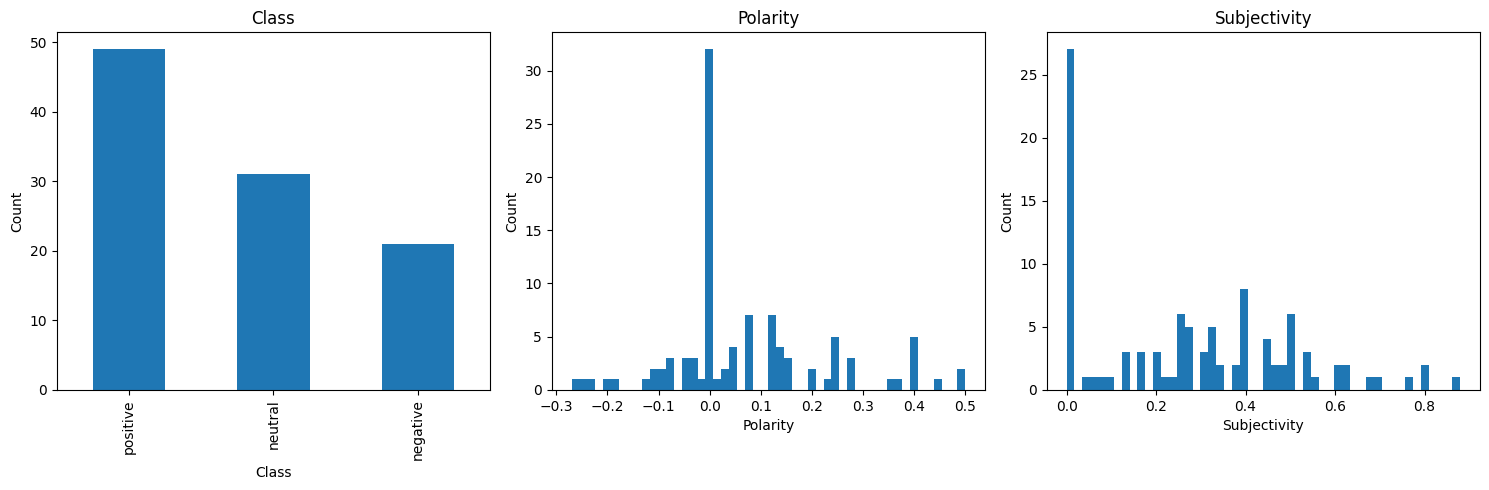

In [33]:
columns_to_plot = ["class", "polarity", "subjectivity"]

fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(5 * len(columns_to_plot), 5))

for i, column in enumerate(columns_to_plot):
    ax = axes[i] 
    if pd.api.types.is_numeric_dtype(df_tweets[column]):
        df_tweets[column].plot.hist(ax=ax, bins=50)
    else:
        df_tweets[column].value_counts().plot.bar(ax=ax)
    ax.set_title(column.capitalize())
    ax.set_xlabel(column.capitalize())
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

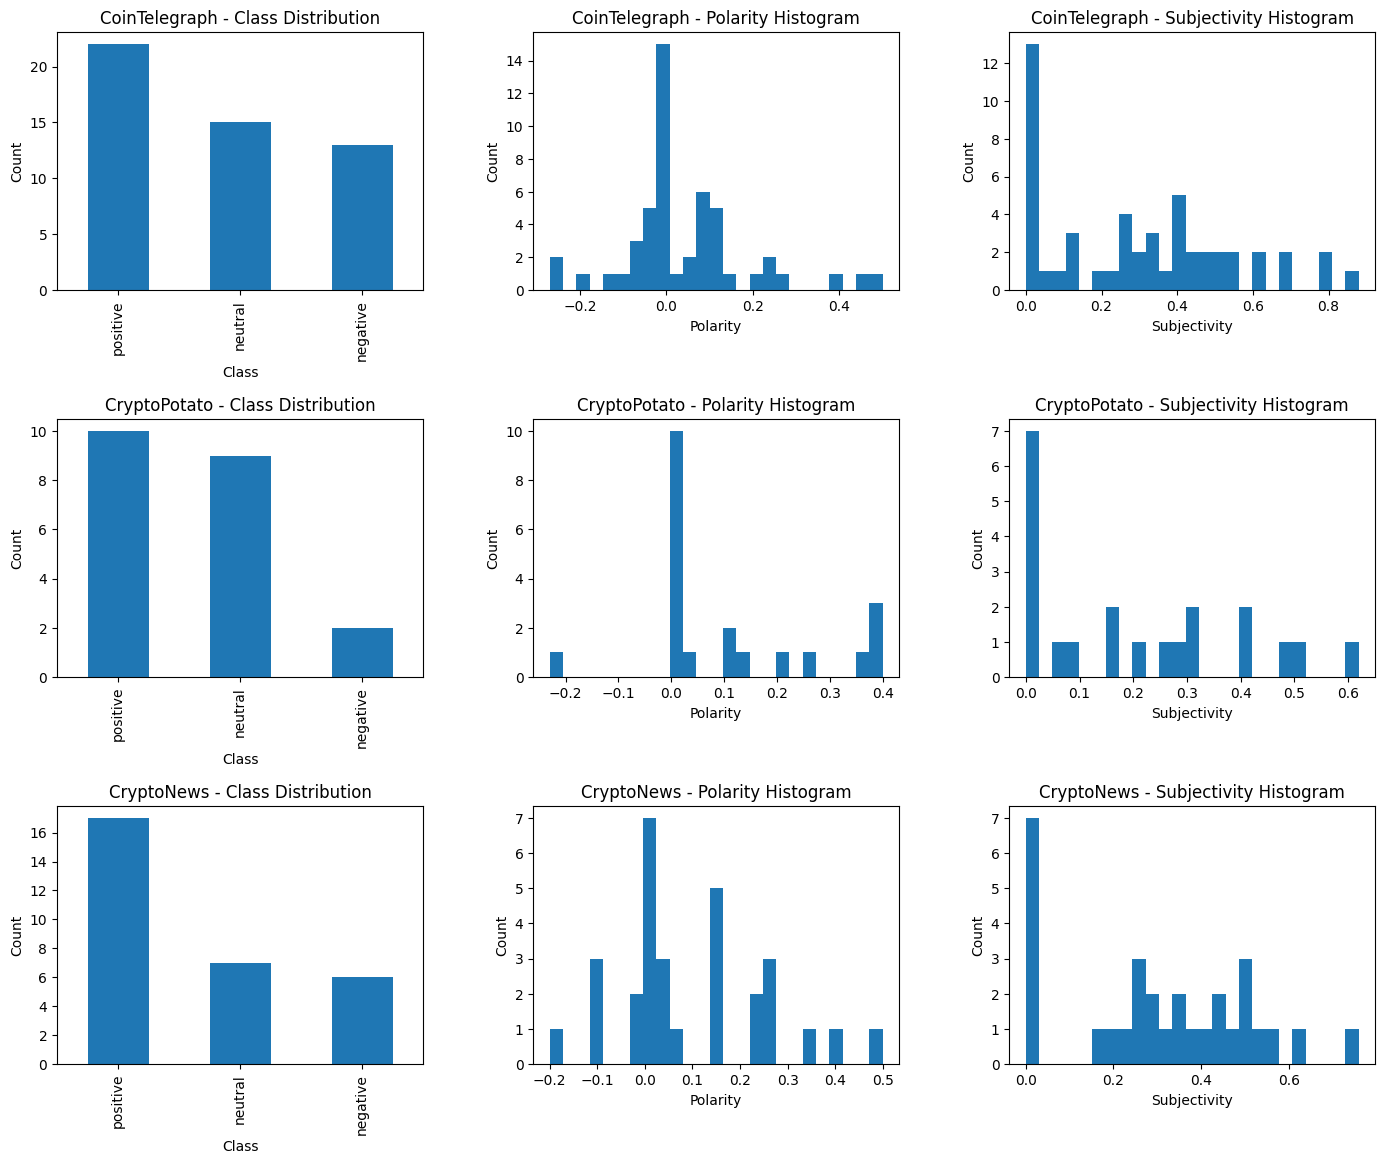

In [34]:
unique_sources = df_tweets["source"].unique()
n_rows = len(unique_sources) # Number of Sources
n_columns = len(columns_to_plot) # Number of columns to analyse

fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 4 * n_columns))
fig.tight_layout(pad=5)

for i, source in enumerate(unique_sources):
    source_data = df_tweets[df_tweets["source"] == source]

    for j, column in enumerate(columns_to_plot):
        ax = axes[i, j] if n_rows > 1 else axes[j]

        if pd.api.types.is_numeric_dtype(source_data[column]):
            source_data[column].plot.hist(ax=ax, bins=25)
            ax.set_title(f'{source} - {column.capitalize()} Histogram')
            ax.set_ylabel('Count')
            ax.set_xlabel(column.capitalize())
        else:
            # Plot categorical columns as bar charts
            source_data[column].value_counts().plot.bar(ax=ax)
            ax.set_title(f'{source} - {column.capitalize()} Distribution')
            ax.set_ylabel('Count')
            ax.set_xlabel(column.capitalize())

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

# Model Pipeline

In [35]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, PreTrainedModel, AutoConfig
from transformers import AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [36]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoConfig

class FinBERTSentimentModel(nn.Module):
    def __init__(self, num_sentiment_classes=3):
        super(FinBERTSentimentModel, self).__init__()
        # Laden des FinBERT-Modells
        self.config = AutoConfig.from_pretrained("ProsusAI/finbert")
        self.finbert = AutoModel.from_pretrained("ProsusAI/finbert", config=self.config)
        hidden_size = self.finbert.config.hidden_size

        # Sentiment Analysis Head
        self.sentiment_classifier = nn.Linear(hidden_size, num_sentiment_classes)
        # Aktivierungsfunktion
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # Ausgaben vom FinBERT-Modell
        outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        # Letzter versteckter Zustand
        last_hidden_state = outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)
        # Verwendung des [CLS]-Tokens als gepoolte Ausgabe
        pooled_output = last_hidden_state[:, 0, :]     # (batch_size, hidden_size)
        
        # Sentiment Analysis (Klassifikation)
        sentiment_logits = self.sentiment_classifier(pooled_output)  # (batch_size, num_sentiment_classes)
        # Optionale Anwendung der Softmax-Funktion
        # sentiment_probs = self.softmax(sentiment_logits)
        
        return sentiment_logits  # oder sentiment_probs, wenn Softmax angewendet wird 

In [37]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class FinBERTFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, model, tokenizer, device='cpu'):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.model.to(self.device)
   
    def fit(self, X, y=None):
        return self
   
    def transform(self, X, y=None):
        self.model.eval()
        features = []
        with torch.no_grad():
            for text in X:
                # Tokenisierung
                encoded_input = self.tokenizer(
                    text,
                    padding='max_length',
                    truncation=True,
                    max_length=128,
                    return_tensors='pt'
                )
                # Übertragen auf das Gerät
                input_ids = encoded_input['input_ids'].to(self.device)
                attention_mask = encoded_input['attention_mask'].to(self.device)
                # Modellvorhersage
                sentiment_logits = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                # In CPU und NumPy konvertieren
                features.append(sentiment_logits.cpu().numpy().squeeze(0))
        return np.array(features)


In [38]:
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    
    def preprocess_text(self, text):
        # Tokenisierung
        tokens = nltk.word_tokenize(text)
        # Lemmatizierung
        lemmatized_tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        # Text rekonstruieren
        return ' '.join(lemmatized_tokens)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [self.preprocess_text(text) for text in X]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\de130063\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\de130063\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [39]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Initialisierung des Tokenizers und des Modells
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = FinBERTSentimentModel()

# Erstellen der Pipeline
sentiment_pipeline = Pipeline(
    steps=[
        ('preprocessor', TextPreprocessor()),
        ('feature_extractor', FinBERTFeatureExtractor(model=model, tokenizer=tokenizer)),
        ('classifier', LogisticRegression(max_iter=1000))
    ],
    verbose=True
)


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

X = df_tweets.drop(["date", "subject", "class", "subjectivity", "polarity"], axis=1)["text"]
targets = df_tweets["class"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.2, random_state=42)

In [41]:
print("Training data shape:", X_train.shape) 
print("Training target data shape:", y_train.shape) 
print("Test data shape:", X_test.shape) 
print("Test target data shape:", y_test.shape)

Training data shape: (80,)
Training target data shape: (80,)
Test data shape: (21,)
Test target data shape: (21,)


In [42]:
display(X_train.head(), y_train.head())

89    PancakeSwap has released version 3 of its BNB ...
26    Shiba Inu price risks dropping 20%  in April a...
42    The Euler Finance team had a happy end after t...
70    Macroeconomic headwinds continue to pressure t...
15    Here is our weekly collection of digital asset...
Name: text, dtype: object

89     neutral
26    positive
42    positive
70    positive
15    positive
Name: class, dtype: object

In [43]:
sentiment_pipeline.fit(X_train, y_train, )

[Pipeline] ...... (step 1 of 3) Processing preprocessor, total=   0.0s
[Pipeline] . (step 2 of 3) Processing feature_extractor, total=  15.2s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('feature_extractor',
                 FinBERTFeatureExtractor(device=device(type='cpu'),
                                         model=FinBERTSentimentModel(
  (finbert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNo...
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
})),
                ('classifier', LogisticRegression(max_iter=1000))],
         verbose=True)

In [44]:
y_pred = sentiment_pipeline.predict(X_test)

In [45]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
display(confusion_matrix(y_test, y_pred))


Accuracy: 0.42857142857142855
Classification Report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00         5
     neutral       0.00      0.00      0.00         5
    positive       0.47      0.82      0.60        11

    accuracy                           0.43        21
   macro avg       0.16      0.27      0.20        21
weighted avg       0.25      0.43      0.31        21



C:\Users\de130063\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\de130063\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\de130063\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

array([[0, 0, 5],
       [0, 0, 5],
       [0, 2, 9]], dtype=int64)

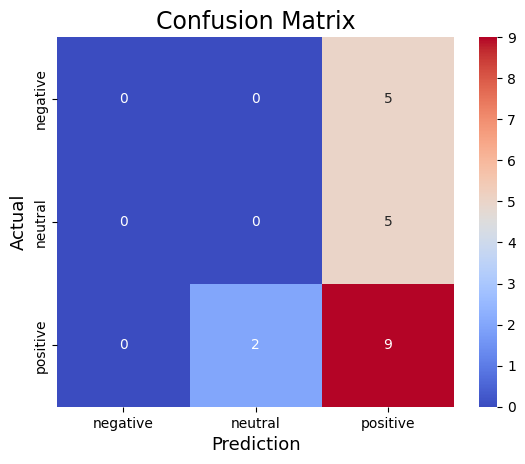

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         5
     neutral       0.00      0.00      0.00         5
    positive       0.47      0.82      0.60        11

    accuracy                           0.43        21
   macro avg       0.16      0.27      0.20        21
weighted avg       0.25      0.43      0.31        21



C:\Users\de130063\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\de130063\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\de130063\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            cmap='coolwarm',
            xticklabels=['negative','neutral', "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))